In [1]:
import sqlite3
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from datetime import datetime
import pandas as pd

In [2]:
conn = sqlite3.connect('dpc.db')

In [3]:
c = conn.cursor()

text = ''
for (t, ft) in c.execute('SELECT text, [extended_tweet.full_text] FROM tweets'):
    if ft:
        text += ft
    else:
        text += t

In [4]:
# Stop words
stop = set(stopwords.words('english'))
stop.update([
    'say',
    'would',
    'year',
    'one',
    'go',
    'get',
    'take',
    'also',
    'need',
    'want',
    'make',
    'family',
    'domestic',
    'violence',
    'mr',
    'people',
    'give',
    'could',
    'day',
    'week',
    'http',
    'via',
    'amp',
    'new',
    'call',
    'domesticviolence',
    'like',
    'see',
    'australia',
    'australian',
    'dv'
])

lmtz = WordNetLemmatizer()

In [5]:
def lemmatize(token):
    lemma = lmtz.lemmatize(token, 'v')
    if lemma == token:
        lemma = lmtz.lemmatize(token, 'n')
    return lemma

In [6]:
freqs = {}
for token in word_tokenize(text):
    if token.isalpha():
        lemma = lemmatize(token.lower())               # Lemmatize word and update its frequency
        if lemma not in stop:
            freqs[lemma] = freqs.get(lemma, 0) + 1

KeyboardInterrupt: 

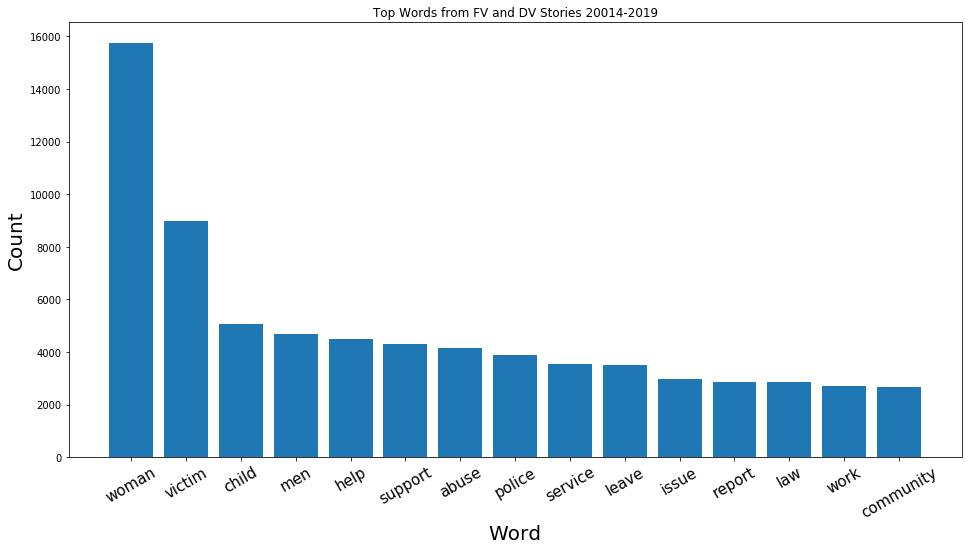

In [48]:
x = []          # X axis - top words
y = []          # Y axis - word counts
count = 0       # Numer of top words to show

for word in sorted(freqs, key=freqs.get, reverse=True):
    x.append(word)
    y.append(freqs[word])
    count += 1
    if count == 15:
        break

plt.figure(figsize=(16,8))
index = np.arange(len(x))
plt.bar(index, y)
plt.xlabel('Word', fontsize=20)
plt.ylabel('Count', fontsize=20)
plt.xticks(index, x, fontsize=15, rotation=30)
plt.title('Top Words from FV and DV Stories 20014-2019')
plt.show()

# Monthly Counts

In [7]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
years = ['2014','2015','2016','2017','2018','2019']
year_months = []
for year in years:
    for month in months:
        if year == '2019' and month == 'May':
            break
        year_months.append(year+'-'+month)

len(year_months)

64

In [8]:
def compute_month_distance(date, curr_year, curr_month):
    if date.year == curr_year:
        return date.month-curr_month
    else:
        return date.month+12-curr_month

In [13]:
available_tweet_counts = []

n = 0
curr_year = 2014
curr_month = 1
for (s,) in c.execute('SELECT created_at FROM tweets'):
    splits = s.split(' ')
    s = splits[1]+' '+splits[2]+' '+splits[5]
    date = datetime.strptime(s, '%b %d %Y')
    if date.month != curr_month:
        available_tweet_counts.append(n)
        
        # if some months have 0 records, compute how many
#         dist = compute_month_distance(date, curr_year, curr_month)
#         if dist > 1:
#             available_tweet_counts.extend([0]*(dist-1))
            
        curr_month = date.month
        curr_year = date.year
        n = 1
    else:
        n += 1

available_tweet_counts.append(n)
len(available_tweet_counts)

66

In [10]:
total_counts = []

n = 0
curr_month = 1
for (date_str, count) in c.execute('SELECT date, count FROM count_tweets_daily'):
    record_month =int(date_str[4:6])
    if record_month != curr_month:
        total_counts.append(n)
        curr_month = record_month
        n = count
    else:
        n += count

total_counts.append(n)
len(total_counts)

64

In [11]:
df = pd.DataFrame.from_dict({
    'year_month': year_months, 
    'available_tweet_count': available_tweet_counts,
    'total_count': total_counts
})
df.set_index('year_month')

ValueError: arrays must all be same length

In [89]:
conn.close()